# HCM Project: ML on EHR Data

In [212]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn

# Common imports
import numpy as np
import os
import xlrd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [118]:
# Import data 
import pandas as pd 
data = pd.read_excel('/home/beepul/HCM-Project/HCM_Methods_Data/OrganizedData/EHR_Data/HCM_Table_NO_Outcomes.xls')

In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819 entries, 0 to 818
Columns: 115 entries, MRN to MI
dtypes: datetime64[ns](1), float64(45), int64(1), object(68)
memory usage: 735.9+ KB


In [120]:
pd.set_option('display.max_columns',120)
data.head()
data.shape

,MRN,MRN_MRI,MRI_ID,Last_Name_MRI,First_Name_Initial_MRI,Record_ID,LastName,FirstName,excl_myect,Myectomy,ASA,GENDER,ANGINA,DYSPNEAatexertion,DIZZINESS,PRESYNCOPE,SYNCOPE,H_DM,HCMtype,Race,NYHA,Smoking,Metformin,Insulin,H_HTN,H_DL,Statin,H_stroke,H_CAD,H_MI,Antiplt,ICDbase,FHx_HCM,Bbloq,Cabloq,ACEi_ARB,Diuretic,Disopyramide,SAM,MR,Protocol,Reasonfortermination,ABPR,FHx_SCD,IVS_3,H_Afib,H_NSVT,SVT,NSVT,NewAFib,NYHA2,EPS_VT,height_m,weight_kg,BMI,AGE,Cr,Total_myocardial_mass_g,Scar_tissue_mass_g,Scar_tissue_volumem_L,LGE_%,EF,LVEDV,LVESV,LA,MV_E,MV_A,EA,MV_DecT,EE,LVOT_Rest,LVOT_Stress,IVS_max,PW,IVS_PW,Apex,Global_S_G,Global_SR_S,Global_SR_E,ExerTime,METS,HR_rest,SBP_rest,DBP_rest,HR_stress,SBP_stress,DBP_stress,Percentage_of_MaxHr,HR_recovery_60s,LGE,Ranolazine,ApicalHCM,CKD,DOB,MRI_parameter,Echo_parameter,TET_parameter,H_NSVT_N,H_VTVF,H_VTVF_N,H_ICDShock_N,H_ATP,Outcome_during_FU,NSVT_N,VTVF,VTVF_N,ICDimplantation,ICDshock,ICDshock_Number,AntiTachycardiaPacing,HF,Transplantation,Death,Stroke,MI
0,JH15025246,JH15025246,2,Abdelrahman,T,10659.0,Abdelrahman,Elwalid,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,2.0,2,NaN,NaN,1.0,0,0,0.0,0.0,0.0,0,0.0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0.0,,,,NaN,NaN,1.8288,98.064,29.320892,39.211499,NaN,300.01,58.15,55.38,19,67,79,26,5.1,1.27,0.974,1.4,266,27,20,50,3.2,1.2,2.666667,1,-7.4825,-0.66625,0.503125,550.0,10.5,68,146,81,162.0,204,85,89.5,130,1,,NaN,NaN,1973-02-08,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,NaN,NaN,,NaN,,NaN,NaN,NaN,,,,,
1,JH90696195,JH90696195,3,Abron,C,10001.0,Abron,Timothy,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,2,2.0,0,NaN,NaN,1.0,1,1,0.0,1.0,0.0,1,0.0,0,0,0,1,1,0,1,1,2,3,1,1,0,0,0.0,1,0,0,2.0,0.0,1.7526,107.598,35.029875,71.118412,0.9,160.46,30.96,NaN,19.3,56,71,31,4.5,0.48,0.81,0.62,371,14,10,16,1.7,1.5,1.100000,1.9,-16.978333,-0.966111,0.982222,192.0,2.3,95,138,80,120.0,63,37,83,90,1,,NaN,NaN,1938-02-12,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,NaN,0.0,0,0.0,1,0.0,0.0,0.0,0,0,0,0,0
2,JH86623981,JH86623981,4,Adams,I,20052.0,Adams,David,0.0,NaN,NaN,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1,1.0,0,0.0,0.0,1.0,1,1,0.0,0.0,0.0,0,0.0,1,0,0,0,0,0,0,1,1,1,1,0,,0,NaN,,,,NaN,NaN,1.727,76.204,25.550129,54.000000,NaN,NaN,NaN,NaN,,,,,3.3,0.298,0.447,0.67,172,7,4,12,1.3,0.9,1.444444,,,,,730.0,13.7,75,87,58,155.0,94,52,95,144,,0,NaN,0.0,1962-08-16,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,,NaN,NaN,NaN,,,,,
3,JH14339131,JH14339131,5,Adipudi,C,10201.0,Adipudi,Ramesh,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1.0,0,NaN,NaN,0.0,1,1,0.0,0.0,0.0,1,0.0,0,1,0,0,0,0,2,1,1,0,0,0,0,0,0.0,0,0,0,1.0,0.0,1.7018,70.37,24.297999,41.215606,1,NaN,NaN,NaN,,59.070818,121.63,49.78,4.4,1.136415,0.726567,1.564087,158.52439,19,68,146,2.6,1.1,2.363636,0.793761,-13.729608,-1.317255,1.382353,620.0,12.3,74,114,66,166.0,149,77,93,129,0,,NaN,NaN,1967-05-28,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,NaN,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0,0,0
4,JH94072597,JH94072597,6,Adkins,T,10002.0,Adkins,Charles,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,2,NaN,NaN,1.0,1,1,0.0,0.0,0.0,1,0.0,0,1,1,1,0,0,2,1,1,4,0,0,0,0,0.0,0,0,0,1.0,0.0,1.8034,91.254,28.058715,61.363450,0.7,NaN,NaN,NaN,,67.76,125.78,40.55,5.1,0.73,0.946475,0.770356,171.83,15,24,41,1.8,1.4,1.285714,1.174048,-16.47,-1.141111,1.080556,398.0,7.8,65,133,58,141.0,162,48,88.7,130,0,,NaN,NaN,1947-05-02,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,NaN,0.0,1,1.0,1,0.0,0.0,0.0,1,0,0,0,0


(819, 115)

In [121]:
# Make all the features numerical not object types
for i in range(8,115):
    data.iloc[:,i] = pd.to_numeric(data.iloc[:,i],errors='coerce')

In [122]:
# We want to determine all patients whose hearts are capable of an arrythmia
# So an outcome would be if they have ever had VT/VF
# Dropping all patients who dont have all of these outcomes
data = data.dropna(subset=['H_VTVF','VTVF'], how='all')

In [123]:
outcomes = data[['VTVF','H_VTVF']].any(axis=1)
outcomes.value_counts()

False    676
True      31
dtype: int64

In [124]:
# Left with 707 patients who have an outcome
data.shape

(707, 115)

In [125]:
# Need to create an outcomes label vector
# Number of patients who have had an adverse cardiac outcome related ventricular activity
# look into NYHA/HF combination possibly
outcomes = data[['H_VTVF','VTVF','H_VTVF_N','VTVF_N']].any(axis=1)
outcomes.value_counts()

False    676
True      31
dtype: int64

In [126]:
# Label Vector
data['Adverse_Outcome'] = outcomes.astype(int)

In [127]:
data.head()

,MRN,MRN_MRI,MRI_ID,Last_Name_MRI,First_Name_Initial_MRI,Record_ID,LastName,FirstName,excl_myect,Myectomy,ASA,GENDER,ANGINA,DYSPNEAatexertion,DIZZINESS,PRESYNCOPE,SYNCOPE,H_DM,HCMtype,Race,NYHA,Smoking,Metformin,Insulin,H_HTN,H_DL,Statin,H_stroke,H_CAD,H_MI,Antiplt,ICDbase,FHx_HCM,Bbloq,Cabloq,ACEi_ARB,Diuretic,Disopyramide,SAM,MR,Protocol,Reasonfortermination,ABPR,FHx_SCD,IVS_3,H_Afib,H_NSVT,SVT,NSVT,NewAFib,NYHA2,EPS_VT,height_m,weight_kg,BMI,AGE,Cr,Total_myocardial_mass_g,Scar_tissue_mass_g,Scar_tissue_volumem_L,LGE_%,EF,LVEDV,LVESV,LA,MV_E,MV_A,EA,MV_DecT,EE,LVOT_Rest,LVOT_Stress,IVS_max,PW,IVS_PW,Apex,Global_S_G,Global_SR_S,Global_SR_E,ExerTime,METS,HR_rest,SBP_rest,DBP_rest,HR_stress,SBP_stress,DBP_stress,Percentage_of_MaxHr,HR_recovery_60s,LGE,Ranolazine,ApicalHCM,CKD,DOB,MRI_parameter,Echo_parameter,TET_parameter,H_NSVT_N,H_VTVF,H_VTVF_N,H_ICDShock_N,H_ATP,Outcome_during_FU,NSVT_N,VTVF,VTVF_N,ICDimplantation,ICDshock,ICDshock_Number,AntiTachycardiaPacing,HF,Transplantation,Death,Stroke,MI,Adverse_Outcome
0,JH15025246,JH15025246,2,Abdelrahman,T,10659.0,Abdelrahman,Elwalid,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.8288,98.064,29.320892,39.211499,NaN,300.01,58.15,55.38,19.0,67.000000,79.00,26.00,5.1,1.270000,0.974000,1.400000,266.00000,27.0,20.0,50.0,3.2,1.2,2.666667,1.000000,-7.482500,-0.666250,0.503125,550.0,10.5,68.0,146.0,81.0,162.0,204.0,85.0,89.5,130.0,1.0,NaN,NaN,NaN,97977600000000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,JH90696195,JH90696195,3,Abron,C,10001.0,Abron,Timothy,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,NaN,NaN,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.7526,107.598,35.029875,71.118412,0.9,160.46,30.96,NaN,19.3,56.000000,71.00,31.00,4.5,0.480000,0.810000,0.620000,371.00000,14.0,10.0,16.0,1.7,1.5,1.100000,1.900000,-16.978333,-0.966111,0.982222,192.0,2.3,95.0,138.0,80.0,120.0,63.0,37.0,83.0,90.0,1.0,NaN,NaN,NaN,-1006214400000000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,JH14339131,JH14339131,5,Adipudi,C,10201.0,Adipudi,Ramesh,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.7018,70.370,24.297999,41.215606,1.0,NaN,NaN,NaN,NaN,59.070818,121.63,49.78,4.4,1.136415,0.726567,1.564087,158.52439,19.0,68.0,146.0,2.6,1.1,2.363636,0.793761,-13.729608,-1.317255,1.382353,620.0,12.3,74.0,114.0,66.0,166.0,149.0,77.0,93.0,129.0,0.0,NaN,NaN,NaN,-81993600000000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,JH94072597,JH94072597,6,Adkins,T,10002.0,Adkins,Charles,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.8034,91.254,28.058715,61.363450,0.7,NaN,NaN,NaN,NaN,67.760000,125.78,40.55,5.1,0.730000,0.946475,0.770356,171.83000,15.0,24.0,41.0,1.8,1.4,1.285714,1.174048,-16.470000,-1.141111,1.080556,398.0,7.8,65.0,133.0,58.0,141.0,162.0,48.0,88.7,130.0,0.0,NaN,NaN,NaN,-715392000000000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
5,JH63926262,JH63926262,7,AGUILAR,R,10003.0,AGUILAR,ISABEL,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.7018,52.210,18.027548,25.073238,0.5,222.63,26.96,25.68,12.0,53.000000,59.63,28.19,4.9,1.140000,0.770000,2.500000,140.00000,NaN,NaN,135.0,1.7,1.0,1.700000,1.100000,-12.721667,-1.022778,1.235556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,333417600000000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0

In [128]:
# Removing identifying variables (Names, IDs, etc)
data = data.drop(data.loc[:, 'MRN':'FirstName'].columns, axis = 1)
# Removing DOB
data = data.drop('DOB', axis = 1)

In [129]:
# Removing Empty or Nearly Empty Columns
data = data.drop(['MRI_parameter','Echo_parameter','TET_parameter','Outcome_during_FU',
                  'Ranolazine','ApicalHCM','CKD'], axis = 1)

In [130]:
# Removing counts of Variables (_N)
data = data.drop(['H_NSVT_N','H_VTVF_N','NSVT_N','VTVF_N'], axis=1)

In [131]:
# Removing ICD Related Features
data = data.drop(data.loc[:, 'ICDshock':'HF'].columns, axis = 1)

In [132]:
# Removing Adverse Outcomes related to Ventricular Activity
data = data.drop(['H_VTVF','VTVF','H_ATP','H_ICDShock_N'], axis = 1)

In [133]:
# Removing Adverse Outcomes related to Ventricular Activity
data = data.drop(['Death'], axis = 1)

In [134]:
# Removing LGE
data = data.drop(['LGE'], axis = 1)

In [135]:
# Removing Adverse Outcomes related to Ventricular Activity
data = data.drop(['Transplantation','Stroke'], axis = 1)

In [136]:
data.head()
data.shape

,excl_myect,Myectomy,ASA,GENDER,ANGINA,DYSPNEAatexertion,DIZZINESS,PRESYNCOPE,SYNCOPE,H_DM,HCMtype,Race,NYHA,Smoking,Metformin,Insulin,H_HTN,H_DL,Statin,H_stroke,H_CAD,H_MI,Antiplt,ICDbase,FHx_HCM,Bbloq,Cabloq,ACEi_ARB,Diuretic,Disopyramide,SAM,MR,Protocol,Reasonfortermination,ABPR,FHx_SCD,IVS_3,H_Afib,H_NSVT,SVT,NSVT,NewAFib,NYHA2,EPS_VT,height_m,weight_kg,BMI,AGE,Cr,Total_myocardial_mass_g,Scar_tissue_mass_g,Scar_tissue_volumem_L,LGE_%,EF,LVEDV,LVESV,LA,MV_E,MV_A,EA,MV_DecT,EE,LVOT_Rest,LVOT_Stress,IVS_max,PW,IVS_PW,Apex,Global_S_G,Global_SR_S,Global_SR_E,ExerTime,METS,HR_rest,SBP_rest,DBP_rest,HR_stress,SBP_stress,DBP_stress,Percentage_of_MaxHr,HR_recovery_60s,ICDimplantation,MI,Adverse_Outcome
0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.8288,98.064,29.320892,39.211499,NaN,300.01,58.15,55.38,19.0,67.000000,79.00,26.00,5.1,1.270000,0.974000,1.400000,266.00000,27.0,20.0,50.0,3.2,1.2,2.666667,1.000000,-7.482500,-0.666250,0.503125,550.0,10.5,68.0,146.0,81.0,162.0,204.0,85.0,89.5,130.0,NaN,NaN,0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,NaN,NaN,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.7526,107.598,35.029875,71.118412,0.9,160.46,30.96,NaN,19.3,56.000000,71.00,31.00,4.5,0.480000,0.810000,0.620000,371.00000,14.0,10.0,16.0,1.7,1.5,1.100000,1.900000,-16.978333,-0.966111,0.982222,192.0,2.3,95.0,138.0,80.0,120.0,63.0,37.0,83.0,90.0,1.0,0.0,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.7018,70.370,24.297999,41.215606,1.0,NaN,NaN,NaN,NaN,59.070818,121.63,49.78,4.4,1.136415,0.726567,1.564087,158.52439,19.0,68.0,146.0,2.6,1.1,2.363636,0.793761,-13.729608,-1.317255,1.382353,620.0,12.3,74.0,114.0,66.0,166.0,149.0,77.0,93.0,129.0,0.0,0.0,0
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.8034,91.254,28.058715,61.363450,0.7,NaN,NaN,NaN,NaN,67.760000,125.78,40.55,5.1,0.730000,0.946475,0.770356,171.83000,15.0,24.0,41.0,1.8,1.4,1.285714,1.174048,-16.470000,-1.141111,1.080556,398.0,7.8,65.0,133.0,58.0,141.0,162.0,48.0,88.7,130.0,1.0,0.0,1
5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.7018,52.210,18.027548,25.073238,0.5,222.63,26.96,25.68,12.0,53.000000,59.63,28.19,4.9,1.140000,0.770000,2.500000,140.00000,NaN,NaN,135.0,1.7,1.0,1.700000,1.100000,-12.721667,-1.022778,1.235556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0


(707, 84)

## Statistical Analysis of Features

In [137]:
# Copy Data for statistical analysis
data_final = data.copy()
Outcome = data_final['Adverse_Outcome']

In [138]:
# Impute Missing data

# Imputing using Iterative Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter = 300)
imputed_data = pd.DataFrame(imputer.fit_transform(data_final),columns = data_final.columns)

In [139]:
imputed_data.head()

,excl_myect,Myectomy,ASA,GENDER,ANGINA,DYSPNEAatexertion,DIZZINESS,PRESYNCOPE,SYNCOPE,H_DM,HCMtype,Race,NYHA,Smoking,Metformin,Insulin,H_HTN,H_DL,Statin,H_stroke,H_CAD,H_MI,Antiplt,ICDbase,FHx_HCM,Bbloq,Cabloq,ACEi_ARB,Diuretic,Disopyramide,SAM,MR,Protocol,Reasonfortermination,ABPR,FHx_SCD,IVS_3,H_Afib,H_NSVT,SVT,NSVT,NewAFib,NYHA2,EPS_VT,height_m,weight_kg,BMI,AGE,Cr,Total_myocardial_mass_g,Scar_tissue_mass_g,Scar_tissue_volumem_L,LGE_%,EF,LVEDV,LVESV,LA,MV_E,MV_A,EA,MV_DecT,EE,LVOT_Rest,LVOT_Stress,IVS_max,PW,IVS_PW,Apex,Global_S_G,Global_SR_S,Global_SR_E,ExerTime,METS,HR_rest,SBP_rest,DBP_rest,HR_stress,SBP_stress,DBP_stress,Percentage_of_MaxHr,HR_recovery_60s,ICDimplantation,MI,Adverse_Outcome
0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.338367,0.023281,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,1.0,1.0,0.0,0.0,0.185024,0.193133,0.073092,1.582566,0.043366,1.8288,98.064,29.320892,39.211499,1.063519,300.010000,58.150000,55.380000,19.000000,67.000000,79.00,26.00,5.1,1.270000,0.974000,1.400000,266.00000,27.000000,20.000000,50.0,3.2,1.2,2.666667,1.000000,-7.482500,-0.666250,0.503125,550.000000,10.500000,68.000000,146.000000,81.000000,162.000000,204.00000,85.00000,89.500000,130.000000,0.395055,0.0044,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.300642,0.214357,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.000000,3.000000,1.000000,1.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,2.000000,0.000000,1.7526,107.598,35.029875,71.118412,0.900000,160.460000,30.960000,27.193460,19.300000,56.000000,71.00,31.00,4.5,0.480000,0.810000,0.620000,371.00000,14.000000,10.000000,16.0,1.7,1.5,1.100000,1.900000,-16.978333,-0.966111,0.982222,192.000000,2.300000,95.000000,138.000000,80.000000,120.000000,63.00000,37.00000,83.000000,90.000000,1.000000,0.0000,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.252905,-0.015753,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.7018,70.370,24.297999,41.215606,1.000000,185.129085,28.720656,28.042060,15.041018,59.070818,121.63,49.78,4.4,1.136415,0.726567,1.564087,158.52439,19.000000,68.000000,146.0,2.6,1.1,2.363636,0.793761,-13.729608,-1.317255,1.382353,620.000000,12.300000,74.000000,114.000000,66.000000,166.000000,149.00000,77.00000,93.000000,129.000000,0.000000,0.0000,0.0
3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.305459,0.146120,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.000000,4.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.8034,91.254,28.058715,61.363450,0.700000,151.216972,-3.152018,-3.727456,4.878646,67.760000,125.78,40.55,5.1,0.730000,0.946475,0.770356,171.83000,15.000000,24.000000,41.0,1.8,1.4,1.285714,1.174048,-16.470000,-1.141111,1.080556,398.000000,7.800000,65.000000,133.000000,58.000000,141.000000,162.00000,48.00000,88.700000,130.000000,1.000000,0.0000,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.191759,-0.139375,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.354437,1.173634,0.426316,1.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,2.000000,0.000000,1.7018,52.210,18.027548,25.073238,0.500000,222.630000,26.960000,25.680000,12.000000,53.000000,59.63,28.19,4.9,1.140000,0.770000,2.500000,140.00000,22.658586,73.123473,135.0,1.7,1.0,1.700000,1.100000,-12.721667,-1.022778,1.235556,786.972563,12.553182,71.470161,120.514755,70.839812,167.037465,136.73486,73.66115,87.588509,126.975612,1.000000,0.0000,0.0


In [140]:
label1 = imputed_data[(Outcome ==1).values]
label0 = imputed_data[(Outcome ==0).values]

In [141]:
# Separating numerical/continuous from data set
num_full = imputed_data.loc[:,'height_m':'HR_recovery_60s']

In [142]:
# Conduct rank sum test for each feature and record p-value
from scipy import stats
features = num_full.columns
features = np.asarray(features)
total = features.shape[0]
pvalue = np.zeros((1,total))
for i, feature in enumerate(features):
    results = stats.ranksums(label1[feature].values,label0[feature].values)
    pvalue[0,i] = results.pvalue

In [143]:
features[pvalue[0] < 0.05]

array(['AGE', 'LVOT_Stress', 'SBP_rest', 'DBP_rest'], dtype=object)

In [144]:
# FDR Correction

# Rank p values from lowest to highest
sorted_pvalues = np.sort(pvalue)
sorted_pval_ind = np.argsort(pvalue)
ranks = stats.rankdata(sorted_pvalues, method='ordinal')

# Choose false discovery rate: Q = 0.01
Q = 0.05;
BH_crit = np.zeros((1,total))
for i in range(0,total):
    BH_crit[0,i] = (ranks[i]/total)*Q

# Find largest p value among the sorted p-values that is less than its corresponding BH_crit
logical = sorted_pvalues < BH_crit
indices = np.where(logical == 1)[1]
max_index = np.max(indices) + 1

# Sort the features just like the p values were sorted
sorted_features = features[sorted_pval_ind]
sig_features = sorted_features[0,:max_index]

In [145]:
sig_features

array(['LVOT_Stress'], dtype=object)

(array([1., 2., 6., 5., 6., 4., 0., 4., 1., 2.]),
 array([ 95., 102., 109., 116., 123., 130., 137., 144., 151., 158., 165.]),
 <BarContainer object of 10 artists>)

(array([113., 437., 118.,   7.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 83., 116., 149., 182., 215., 248., 281., 314., 347., 380., 413.]),
 <BarContainer object of 10 artists>)

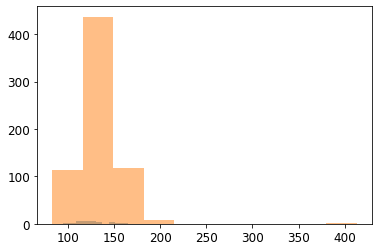

In [146]:
plt.hist(label1['SBP_rest'].values,alpha = 0.5)
plt.hist(label0['SBP_rest'].values,alpha = 0.5)

# Separate Training and Test Data

In [149]:
# Creating training and test set
# This function from sklearn splits the data the same way everytime
# Stratified sampling based on the outcome
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data,test_size=0.2,random_state=42, stratify = data['Adverse_Outcome'])

<AxesSubplot:>

21.6

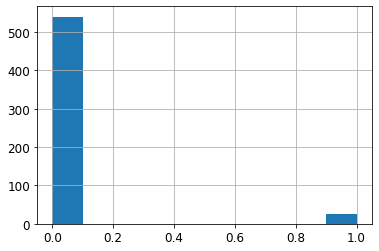

In [150]:
# Checking proportion of positive and negative outcomes in both training and test set
train_set['Adverse_Outcome'].hist()
Proportion = train_set['Adverse_Outcome'].value_counts()[0]/train_set['Adverse_Outcome'].value_counts()[1]
Proportion

<AxesSubplot:>

22.666666666666668

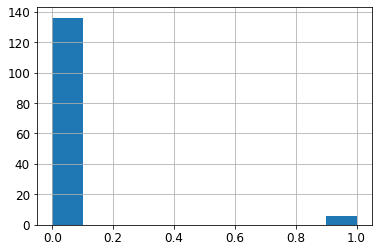

In [151]:
test_set['Adverse_Outcome'].hist()
Proportion = test_set['Adverse_Outcome'].value_counts()[0]/test_set['Adverse_Outcome'].value_counts()[1]
Proportion

In [152]:
# Creating a copy of the training set to work with
training = train_set.copy()
training

,excl_myect,Myectomy,ASA,GENDER,ANGINA,DYSPNEAatexertion,DIZZINESS,PRESYNCOPE,SYNCOPE,H_DM,HCMtype,Race,NYHA,Smoking,Metformin,Insulin,H_HTN,H_DL,Statin,H_stroke,H_CAD,H_MI,Antiplt,ICDbase,FHx_HCM,Bbloq,Cabloq,ACEi_ARB,Diuretic,Disopyramide,SAM,MR,Protocol,Reasonfortermination,ABPR,FHx_SCD,IVS_3,H_Afib,H_NSVT,SVT,NSVT,NewAFib,NYHA2,EPS_VT,height_m,weight_kg,BMI,AGE,Cr,Total_myocardial_mass_g,Scar_tissue_mass_g,Scar_tissue_volumem_L,LGE_%,EF,LVEDV,LVESV,LA,MV_E,MV_A,EA,MV_DecT,EE,LVOT_Rest,LVOT_Stress,IVS_max,PW,IVS_PW,Apex,Global_S_G,Global_SR_S,Global_SR_E,ExerTime,METS,HR_rest,SBP_rest,DBP_rest,HR_stress,SBP_stress,DBP_stress,Percentage_of_MaxHr,HR_recovery_60s,ICDimplantation,MI,Adverse_Outcome
545,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.6256,67.646,25.598513,59.200548,0.9,NaN,NaN,NaN,NaN,63.000000,88.00,33.00,3.5,0.96900,0.599000,1.600000,271.00000,9.700000,6.000000,62.000000,1.400000,1.000000,1.400000,1.100000,-15.499444,-1.137778,1.405556,418.0,9.2,53.0,108.0,72.0,136.0,177.0,94.0,84.5,90.0,0.0,0.0,0
96,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.5748,70.370,28.375057,76.550308,NaN,128.09,20.11,19.16,16.00,82.950000,64.67,11.03,3.7,0.67000,0.954162,0.698442,306.46000,16.000000,4.000000,12.000000,2.000000,1.200000,1.666667,0.715505,-17.711667,-0.913889,1.254444,263.0,6.2,74.0,144.0,80.0,129.0,191.0,73.0,90.0,106.0,0.0,0.0,0
806,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,3.0,2.0,1.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.7270,78.926,26.462777,61.746749,0.9,332.07,28.89,27.52,9.00,59.000000,113.00,46.00,4.8,0.73000,1.040000,0.700000,260.00000,32.230000,112.000000,133.000000,3.200000,2.300000,1.391304,1.600000,-6.784444,-0.520556,0.295556,534.0,4.6,67.0,170.0,111.0,100.0,231.0,136.0,62.9,82.0,0.0,0.0,0
440,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.7272,74.910,25.110452,46.277892,NaN,173.55,29.62,28.21,17.00,56.498244,77.69,33.79,4.5,0.73020,0.603013,1.210919,233.01687,16.000000,14.776304,23.023055,2.114127,0.821282,2.574179,1.124417,-14.839352,-0.958796,1.029352,783.0,15.2,66.0,132.0,81.0,169.0,131.0,79.0,97.0,131.0,0.0,0.0,0
77,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.7272,101.696,34.089342,70.554415,NaN,204.55,28.19,NaN,13.78,65.000000,116.00,40.00,3.8,1.03000,1.040000,0.990000,189.00000,21.000000,28.000000,51.000000,2.700000,1.200000,2.250000,1.400000,-15.845556,-1.113889,1.097778,540.0,10.4,70.0,121.0,77.0,166.0,203.0,81.0,111.0,134.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.7526,81.720,26.604968,41.300479,NaN,NaN,NaN,NaN,NaN,65.432057,84.23,29.12,3.7,0.83385,0.422271,1.974678,179.46050,12.387024,5.884185,48.000000,1.543221,0.853021,1.809124,0.692029,-18.091667,-1.040000,1.492222,1011.0,19.9,61.0,125.0,69.0,181.0,164.0,122.0,101.0,129.0,0.0,0.0,0
252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0

In [153]:
# Creating copies of the features and labels
# Features ONLY
training = train_set.drop("Adverse_Outcome", axis=1)
# Labels ONLY
training_labels = train_set["Adverse_Outcome"].copy()
training

,excl_myect,Myectomy,ASA,GENDER,ANGINA,DYSPNEAatexertion,DIZZINESS,PRESYNCOPE,SYNCOPE,H_DM,HCMtype,Race,NYHA,Smoking,Metformin,Insulin,H_HTN,H_DL,Statin,H_stroke,H_CAD,H_MI,Antiplt,ICDbase,FHx_HCM,Bbloq,Cabloq,ACEi_ARB,Diuretic,Disopyramide,SAM,MR,Protocol,Reasonfortermination,ABPR,FHx_SCD,IVS_3,H_Afib,H_NSVT,SVT,NSVT,NewAFib,NYHA2,EPS_VT,height_m,weight_kg,BMI,AGE,Cr,Total_myocardial_mass_g,Scar_tissue_mass_g,Scar_tissue_volumem_L,LGE_%,EF,LVEDV,LVESV,LA,MV_E,MV_A,EA,MV_DecT,EE,LVOT_Rest,LVOT_Stress,IVS_max,PW,IVS_PW,Apex,Global_S_G,Global_SR_S,Global_SR_E,ExerTime,METS,HR_rest,SBP_rest,DBP_rest,HR_stress,SBP_stress,DBP_stress,Percentage_of_MaxHr,HR_recovery_60s,ICDimplantation,MI
545,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.6256,67.646,25.598513,59.200548,0.9,NaN,NaN,NaN,NaN,63.000000,88.00,33.00,3.5,0.96900,0.599000,1.600000,271.00000,9.700000,6.000000,62.000000,1.400000,1.000000,1.400000,1.100000,-15.499444,-1.137778,1.405556,418.0,9.2,53.0,108.0,72.0,136.0,177.0,94.0,84.5,90.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.5748,70.370,28.375057,76.550308,NaN,128.09,20.11,19.16,16.00,82.950000,64.67,11.03,3.7,0.67000,0.954162,0.698442,306.46000,16.000000,4.000000,12.000000,2.000000,1.200000,1.666667,0.715505,-17.711667,-0.913889,1.254444,263.0,6.2,74.0,144.0,80.0,129.0,191.0,73.0,90.0,106.0,0.0,0.0
806,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,3.0,2.0,1.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.7270,78.926,26.462777,61.746749,0.9,332.07,28.89,27.52,9.00,59.000000,113.00,46.00,4.8,0.73000,1.040000,0.700000,260.00000,32.230000,112.000000,133.000000,3.200000,2.300000,1.391304,1.600000,-6.784444,-0.520556,0.295556,534.0,4.6,67.0,170.0,111.0,100.0,231.0,136.0,62.9,82.0,0.0,0.0
440,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.7272,74.910,25.110452,46.277892,NaN,173.55,29.62,28.21,17.00,56.498244,77.69,33.79,4.5,0.73020,0.603013,1.210919,233.01687,16.000000,14.776304,23.023055,2.114127,0.821282,2.574179,1.124417,-14.839352,-0.958796,1.029352,783.0,15.2,66.0,132.0,81.0,169.0,131.0,79.0,97.0,131.0,0.0,0.0
77,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.7272,101.696,34.089342,70.554415,NaN,204.55,28.19,NaN,13.78,65.000000,116.00,40.00,3.8,1.03000,1.040000,0.990000,189.00000,21.000000,28.000000,51.000000,2.700000,1.200000,2.250000,1.400000,-15.845556,-1.113889,1.097778,540.0,10.4,70.0,121.0,77.0,166.0,203.0,81.0,111.0,134.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.7526,81.720,26.604968,41.300479,NaN,NaN,NaN,NaN,NaN,65.432057,84.23,29.12,3.7,0.83385,0.422271,1.974678,179.46050,12.387024,5.884185,48.000000,1.543221,0.853021,1.809124,0.692029,-18.091667,-1.040000,1.492222,1011.0,19.9,61.0,125.0,69.0,181.0,164.0,122.0,101.0,129.0,0.0,0.0
252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.7526,86.260,28.083022,53.9356

In [154]:
# Separating Categorical/Nominal Features from Continuous for full sets 
num = training.loc[:,'height_m':'HR_recovery_60s']
cat = training.loc[:,'excl_myect':'EPS_VT']
cat = pd.concat([cat,training.loc[:,'ICDimplantation':'MI']], axis = 1)

## Machine Learning

In [155]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn import calibration
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer

In [156]:
# Imputing using Iterative Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter = 100)
training_impute = pd.DataFrame(imputer.fit_transform(training),columns = training.columns)

In [157]:
training_impute.shape

(565, 83)

In [158]:
# Pipeline for continuous features
num_pipeline = Pipeline([('std_scaler', StandardScaler())])

In [159]:
# Pipeline for categorical features
cat_encoder = OneHotEncoder(handle_unknown = 'ignore')
cat_pipeline = Pipeline([('cat_encoder',cat_encoder)])

In [160]:
# Round all categorical variables
training_final = training_impute.copy()
for features in cat.columns:
    training_final[features] = np.round(training_final[features])

In [161]:
training_final.head()

,excl_myect,Myectomy,ASA,GENDER,ANGINA,DYSPNEAatexertion,DIZZINESS,PRESYNCOPE,SYNCOPE,H_DM,HCMtype,Race,NYHA,Smoking,Metformin,Insulin,H_HTN,H_DL,Statin,H_stroke,H_CAD,H_MI,Antiplt,ICDbase,FHx_HCM,Bbloq,Cabloq,ACEi_ARB,Diuretic,Disopyramide,SAM,MR,Protocol,Reasonfortermination,ABPR,FHx_SCD,IVS_3,H_Afib,H_NSVT,SVT,NSVT,NewAFib,NYHA2,EPS_VT,height_m,weight_kg,BMI,AGE,Cr,Total_myocardial_mass_g,Scar_tissue_mass_g,Scar_tissue_volumem_L,LGE_%,EF,LVEDV,LVESV,LA,MV_E,MV_A,EA,MV_DecT,EE,LVOT_Rest,LVOT_Stress,IVS_max,PW,IVS_PW,Apex,Global_S_G,Global_SR_S,Global_SR_E,ExerTime,METS,HR_rest,SBP_rest,DBP_rest,HR_stress,SBP_stress,DBP_stress,Percentage_of_MaxHr,HR_recovery_60s,ICDimplantation,MI
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.6256,67.646,25.598513,59.200548,0.900000,143.27052,22.148586,21.226155,12.903746,63.000000,88.00,33.00,3.5,0.9690,0.599000,1.600000,271.00000,9.70,6.000000,62.000000,1.400000,1.000000,1.400000,1.100000,-15.499444,-1.137778,1.405556,418.0,9.2,53.0,108.0,72.0,136.0,177.0,94.0,84.5,90.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.5748,70.370,28.375057,76.550308,1.278501,128.09000,20.110000,19.160000,16.000000,82.950000,64.67,11.03,3.7,0.6700,0.954162,0.698442,306.46000,16.00,4.000000,12.000000,2.000000,1.200000,1.666667,0.715505,-17.711667,-0.913889,1.254444,263.0,6.2,74.0,144.0,80.0,129.0,191.0,73.0,90.0,106.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,3.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.7270,78.926,26.462777,61.746749,0.900000,332.07000,28.890000,27.520000,9.000000,59.000000,113.00,46.00,4.8,0.7300,1.040000,0.700000,260.00000,32.23,112.000000,133.000000,3.200000,2.300000,1.391304,1.600000,-6.784444,-0.520556,0.295556,534.0,4.6,67.0,170.0,111.0,100.0,231.0,136.0,62.9,82.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.7272,74.910,25.110452,46.277892,0.724621,173.55000,29.620000,28.210000,17.000000,56.498244,77.69,33.79,4.5,0.7302,0.603013,1.210919,233.01687,16.00,14.776304,23.023055,2.114127,0.821282,2.574179,1.124417,-14.839352,-0.958796,1.029352,783.0,15.2,66.0,132.0,81.0,169.0,131.0,79.0,97.0,131.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.7272,101.696,34.089342,70.554415,0.967501,204.55000,28.190000,26.759990,13.780000,65.000000,116.00,40.00,3.8,1.0300,1.040000,0.990000,189.00000,21.00,28.000000,51.000000,2.700000,1.200000,2.250000,1.400000,-15.845556,-1.113889,1.097778,540.0,10.4,70.0,121.0,77.0,166.0,203.0,81.0,111.0,134.0,0.0,0.0


In [162]:
# Using column transformer to apply necessary transformations to numerical and categorial variables and combine them
from sklearn.compose import ColumnTransformer
num_attribs = list(num)
cat_attribs = list(cat)
transformer = ColumnTransformer([
        ("cat", cat_pipeline, cat_attribs),
        ("num", num_pipeline , num_attribs),
    ])

In [163]:
# Another function to plot ROC_Curves
# Used when predict_proba is not an option
def plot_ROC(model,training,training_labels):
    clf = model
    X = training
    y = training_labels.values
    y_pred_roc = np.zeros_like(y)
    mean_fpr = np.linspace(0,1,100)
    tprs = []
    aucs = []
    clf_old = clf 
    fig,ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X,y)):
        X_transform = clf[0].fit_transform(X.iloc[train])
        SGDfit = clf[1].fit(X_transform,y[train])
        prob_clf = calibration.CalibratedClassifierCV(base_estimator = SGDfit,
                                                  method='sigmoid', cv='prefit').fit(X_transform,
                                                                                     y[train].astype(bool))
        Xtest = clf[0].transform(X.iloc[test])
        y_pred = prob_clf.predict_proba(Xtest)
        print(np.max(y_pred))
        print(np.shape(y_pred))
        fpr, tpr, thresholds = metrics.roc_curve(y_true = y[test].astype(bool), y_score = y_pred[:,1])
        dist_to_corner = np.sqrt((1-tpr)**2 + fpr**2)
        opt_threshold = thresholds[np.where(dist_to_corner == np.min(dist_to_corner))]
        # y_pred_roc[test] = y_pred >= opt_threshold
        print(opt_threshold)
        print(y[test])
        auc = metrics.roc_auc_score(y_true = y[test].astype(bool), y_score = y_pred[:,1])
       # ax.plot(fpr, tpr, label = 'ROC fold {}'.format(i), alpha=0.3)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label = r'Mean ROC (AUC=%0.2f$\pm$%0.2f)' % (mean_auc, std_auc),alpha=0.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha = 0.2)
    plt.plot([0,1],[0,1],'k--')
    plt.ylim([0,1.05])
    plt.xlim([0,1.05])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc = 'lower right')

## SGD Classifier

In [63]:
# Train the model
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'log',random_state=42)
SGD_pipeline = Pipeline([('transform', transformer),('SGD',sgd_clf)])
SGD_pipeline.fit(training_final,training_labels)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['excl_myect', 'Myectomy',
                                                   'ASA', 'GENDER', 'ANGINA',
                                                   'DYSPNEAatexertion',
                                                   'DIZZINESS', 'PRESYNCOPE',
                                                   'SYNCOPE', 'H_DM', 'HCMtype',
                                                   'Race', 'NYHA', 'Smoking',
                                                   'Metformin', 'Insulin',
                                                   'H_HTN', 'H_DL', 'Statin',
                                                   'H_stroke', 'H_CAD'...
                              

In [65]:
# Evaluating the model on training set
sgd_predict = SGD_pipeline.predict(training_final)

# Confusion Matrix
confusion_matrix(training_labels, sgd_predict)

array([[522,  18],
       [  4,  21]])

In [66]:
# Precision Score
precision_score(training_labels, sgd_predict)

# Recall Score
recall_score(training_labels, sgd_predict)

# F1 Score
f1_score(training_labels,sgd_predict)

0.5384615384615384

0.84

0.6562499999999999

In [67]:
# Cross Validation
score = {'F1 Score':'f1',
          'AUC':'roc_auc',
          'Precision':'precision',
          'Recall':'recall'} 

cv = StratifiedKFold(random_state=42, shuffle=True)

training_labels_predict = cross_val_predict(SGD_pipeline,
                                           training_final,
                                           training_labels, cv=cv)

training_labels_scores = cross_validate(SGD_pipeline,
                                           training_final,
                                           training_labels, cv=cv, scoring=score)
                                  
# Confusion Matrix
confusion_matrix(training_labels, training_labels_predict)

array([[518,  22],
       [ 20,   5]])

In [68]:
# Precision Score
np.mean(training_labels_scores['test_Precision'])

# Recall Score
np.mean(training_labels_scores['test_Recall'])

# F1 Score
np.mean(training_labels_scores['test_F1 Score'])

0.135

0.2

0.1552136752136752

0.9999999697027687
(113, 2)
[0.00513132]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
1.0
(113, 2)
[0.00163829]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0]
1.0
(113, 2)
[0.5462122]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
0.9999999999760308
(113, 2)
[0.03725512]
[0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0

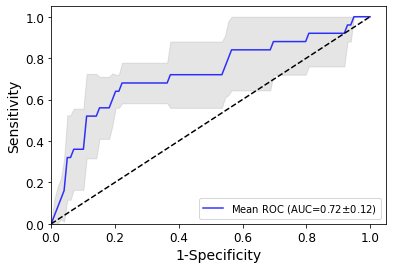

In [69]:
# ROC Curve
plot_ROC(SGD_pipeline,training_final, training_labels)

In [71]:
# Creating dictionary of parameters for randomized search
from scipy import stats
SGD_params = dict(SGD__loss = ['log'],
              SGD__penalty = ['l1','l2','elasticnet'],
              SGD__alpha = [0.0001,0.001,0.01,0.1,1,10,100],
              SGD__l1_ratio = np.linspace(0.01,0.99,99),
              SGD__class_weight = ['balanced'])

In [72]:
# RandomizedSearch
# Returns the SGD pipeline that maximizes AUC
from sklearn.model_selection import GridSearchCV
sgd_random = GridSearchCV(estimator = SGD_pipeline, param_grid = SGD_params,
                               cv = cv, verbose=10, n_jobs = -1, scoring = score, refit = 'F1 Score')
sgd_random.fit(training_final, training_labels)

Fitting 5 folds for each of 2079 candidates, totalling 10395 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('cat_encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['excl_myect',
                                                                          'Myectomy',
                                                                          'ASA',
                                                                          'GENDER',
                                                                          'ANGINA',
                                                                          'DYSPNEAatexertion',
                                   

In [84]:
final_sgd = sgd_random.best_estimator_
sgd_random.best_params_

{'SGD__alpha': 0.01,
 'SGD__class_weight': 'balanced',
 'SGD__l1_ratio': 0.45,
 'SGD__loss': 'log',
 'SGD__penalty': 'elasticnet'}

In [85]:
training_labels_predict_f = cross_val_predict(final_sgd,
                                           training_final,
                                           training_labels, cv=cv)

training_labels_scores_f = cross_validate(final_sgd,
                                           training_final,
                                           training_labels, cv=cv, scoring=score)
                                  
# Confusion Matrix
confusion_matrix(training_labels, training_labels_predict_f)

array([[493,  47],
       [ 11,  14]])

## XGB Classifier

In [169]:
# XGB Pipeline
# Does not impute missing data bc it takes care of them

from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

num_attribs = list(num)
cat_attribs = list(cat)

xgb_clf = XGBClassifier(booster = 'gbtree',random_state = 42, eval_metric = 'logloss', use_label_encoder=False)
xgb_num_pipeline = Pipeline([('mmscaler', MinMaxScaler())])

xgb_transformer = ColumnTransformer([
        ("cat", cat_pipeline, cat_attribs),
        ("num", xgb_num_pipeline , num_attribs),
    ])

In [170]:
xgb_pipeline = Pipeline([('xgbtransform', xgb_transformer),('XGB',xgb_clf)])

In [171]:
# Training and Label Vectors
xgb_train = training
xgb_labels = training_labels

In [172]:
# Training the model
xgb_pipeline.fit(xgb_train,xgb_labels)

Pipeline(steps=[('xgbtransform',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['excl_myect', 'Myectomy',
                                                   'ASA', 'GENDER', 'ANGINA',
                                                   'DYSPNEAatexertion',
                                                   'DIZZINESS', 'PRESYNCOPE',
                                                   'SYNCOPE', 'H_DM', 'HCMtype',
                                                   'Race', 'NYHA', 'Smoking',
                                                   'Metformin', 'Insulin',
                                                   'H_HTN', 'H_DL', 'Statin',
                                                   'H_stroke', 'H_C...
                              

In [173]:
# Predictions
xgb_predict = xgb_pipeline.predict(xgb_train)

In [174]:
# Confusion Matrix
confusion_matrix(xgb_labels, xgb_predict)

array([[540,   0],
       [  0,  25]])

In [175]:
# Precision Score 
precision_score(xgb_labels,xgb_predict)

# Recall Score
recall_score(xgb_labels,xgb_predict)

# F1 Score
f1_score(xgb_labels,xgb_predict)

1.0

1.0

1.0

In [176]:
# Cross Validation
from sklearn.model_selection import cross_validate
cv = StratifiedKFold(random_state=42, shuffle=True)

score = {'F1 Score':'f1',
          'AUC':'roc_auc',
          'Precision':'precision',
          'Recall':'recall'} 


xgb_predict_labels = cross_val_predict(xgb_pipeline, xgb_train, xgb_labels, 
                        cv=cv, n_jobs=-1)

xgb_cv_scores = cross_validate(xgb_pipeline,xgb_train,xgb_labels, cv=cv, scoring=score)

# Confusion Matrix
confusion_matrix(training_labels,xgb_predict_labels)

/home/beepul/anaconda3/envs/MLEnv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beepul/anaconda3/envs/MLEnv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beepul/anaconda3/envs/MLEnv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[538,   2],
       [ 25,   0]])

In [177]:
# ROC/AUC
np.mean(xgb_cv_scores['test_AUC'])

0.7885185185185185

In [95]:
# Hyperparameter Tuning
print('Parameters currently in use:\n')
print(xgb_pipeline[1].get_params())

Parameters currently in use:

{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 16, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [182]:
# Scoring and dictionary for randomized search
from scipy import stats

scoring = {'Balanced Accuracy': 'balanced_accuracy',
          'Accuracy': 'accuracy',
          'F1 Score':'f1',
          'AUC':'roc_auc',
          'Precision':'precision',
          'Recall':'recall'} 

objective = ['binary:logistic']
weights = [int(x) for x in np.linspace(1,20, num=20)]
n_estimators = stats.randint(150, 1000)
learning_rate = stats.uniform(0.01, 0.99)
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_child_weight = [1, 2, 3, 4, 5, 6,7,8,9,10]
gamma = stats.uniform(0.01,100)
reg_lambda = stats.uniform(0.001,10)
reg_alpha = stats.uniform(0.001, 10)
subsample = stats.uniform(0.001,1)

xgb_params = dict(XGB__objective = objective,
                 XGB__scale_pos_weight = weights,
                 XGB__n_estimators = n_estimators,
                 XGB__learning_rate = learning_rate,
                 XGB__max_depth = max_depth,
                 XGB__min_child_weight = min_child_weight,
                 XGB__gamma = gamma,
                 XGB__reg_lambda = reg_lambda,
                 XGB__reg_alpha = reg_alpha,
                 XGB__subsample = subsample)

In [183]:
# Randomized Search: Refit to the best F1
xgb_random_F1 = RandomizedSearchCV(estimator = xgb_pipeline, param_distributions = xgb_params, n_iter = 100, 
                               cv = cv, verbose=10, random_state=42, n_jobs = -1, scoring = scoring, refit = 'F1 Score',return_train_score=True)
xgb_random_F1.fit(xgb_train, xgb_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('xgbtransform',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('cat_encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['excl_myect',
                                                                                'Myectomy',
                                                                                'ASA',
                                                                                'GENDER',
                                                                                'ANGINA',
                                                                   

In [184]:
# Best Parameters from Randomized Search for F1 refit
xgb_random_F1.best_params_
xgb_random_F1.best_score_
xgb_best = xgb_random_F1.best_estimator_

{'XGB__gamma': 70.63422271564963,
 'XGB__learning_rate': 0.09053529283548076,
 'XGB__max_depth': 50,
 'XGB__min_child_weight': 6,
 'XGB__n_estimators': 488,
 'XGB__objective': 'binary:logistic',
 'XGB__reg_alpha': 5.814054172267824,
 'XGB__reg_lambda': 8.632385219890038,
 'XGB__scale_pos_weight': 20,
 'XGB__subsample': 0.23768519368207874}

0.2728345567476002

In [100]:
# Precision Score
xgb_random_F1.cv_results_['mean_test_Precision'][xgb_random_F1.best_index_]

# Recall Score
xgb_random_F1.cv_results_['mean_test_Recall'][xgb_random_F1.best_index_]

# F1 Score
xgb_random_F1.cv_results_['mean_test_F1 Score'][xgb_random_F1.best_index_]

# AUC Score
xgb_random_F1.cv_results_['mean_test_AUC'][xgb_random_F1.best_index_]

0.17504913955041834

0.6799999999999999

0.2728345567476002

0.8357407407407408

In [197]:
# Confusion Matrix
best_xgbF1_predict = cross_val_predict(xgb_best, xgb_train, xgb_labels, 
                        cv=cv, n_jobs=-1)

confusion_matrix(xgb_labels, best_xgbF1_predict)

array([[453,  87],
       [  8,  17]])

<AxesSubplot:>

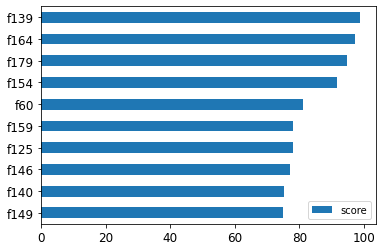

In [185]:
# Feature Importances
feature_important = xgb_best[1].get_booster().get_score(importance_type = 'gain')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh')

In [196]:
xgb_train.columns[49]

'Total_myocardial_mass_g'

## Evaluating on test set

In [200]:
test = test_set.copy()

In [202]:
# Creating copies of the features and labels
# Features ONLY
X_test = test_set.drop("Adverse_Outcome", axis=1)
# Labels ONLY
Y_test = test_set["Adverse_Outcome"].copy()
Y_test.value_counts()

0    136
1      6
Name: Adverse_Outcome, dtype: int64

In [204]:
# Predictions
xgb_final_pred = xgb_best.predict(X_test)

In [205]:
# Confusion Matrix
confusion_matrix(Y_test,xgb_final_pred)

array([[118,  18],
       [  3,   3]])

In [208]:
xgbF1_final_prob = xgb_best.predict_proba(X_test)

In [210]:
# ROC Curve 
# Function to plot ROC_Curves
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    [...] # Add axis labels and grid

0.7653186274509803

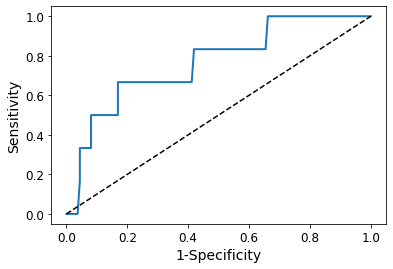

In [211]:
# ROC Curve
xgbF1_test_fpr, xgbF1_test_tpr, xgbF1_test_thresholds = roc_curve(Y_test, xgbF1_final_prob[:,1])
plot_roc_curve(xgbF1_test_fpr, xgbF1_test_tpr)
roc_auc_score(Y_test, xgbF1_final_prob[:,1])